Model Part 5

# GOAL
*   Image augmentation. 
*   Model finalizing 
*   Changed learning rate to 0.4
*   Maintaining consistent accuracy 
*   Fine tuning out some loose ends









# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [0]:
torch.manual_seed(1)
batch_size = 32
use_cuda = torch.cuda.is_available()

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                        transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=False, **kwargs)



# SEED = 1

# # CUDA?
# cuda = torch.cuda.is_available()
# print("CUDA Available?", cuda)

# # For reproducibility
# torch.manual_seed(SEED)

# if cuda:
#     torch.cuda.manual_seed(SEED)

# # dataloader arguments - something you'll fetch these from cmdprmt
# dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# # train dataloader
# train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# # test dataloader
# test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

In [0]:
# # We'd need to convert it into Numpy! Remember above we have converted it into tensors already
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())

# print('[Train]')
# print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train.train_data.size())
# print(' - min:', torch.min(train_data))
# print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# print(images.shape)
# print(labels.shape)

# # Let's visualize some of the images
# # %matplotlib inline
# # import matplotlib.pyplot as plt

# # plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


In [0]:
# figure = plt.figure()
# num_of_images = 60
# for index in range(1, num_of_images + 1):
#     plt.subplot(6, 10, index)
#     plt.axis('off')
#     plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [0]:
drop_val = 0.001
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(drop_val)
        ) # output_size = 28
        # RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #nn.ReLU(),
            nn.Dropout(drop_val)
        ) # output_size = 28
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) # output_size = 28

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 14
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #nn.ReLU(),
            #nn.Dropout(drop_val)
        ) # output_size = 14

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #nn.ReLU(),
            nn.Dropout(drop_val)
        ) # output_size = 14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            #nn.ReLU(),
            #nn.BatchNorm2d(16),
            #nn.Dropout(drop_val),
            #nn.ReLU()
        ) # output_size = 14

        self.pool2 =nn.MaxPool2d(2,2)
        # Output size = 7
        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            #nn.ReLU(),
            nn.Dropout(drop_val)
        ) # 
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            #nn.ReLU(),
            nn.Dropout(drop_val)
        ) 

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7)
        ) # output_size = 1
        
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )
        #self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.pool2(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [5]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
           Dropout-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,440
              ReLU-6           [-1, 16, 28, 28]               0
       BatchNorm2d-7           [-1, 16, 28, 28]              32
           Dropout-8           [-1, 16, 28, 28]               0
            Conv2d-9           [-1, 10, 28, 28]             160
        MaxPool2d-10           [-1, 10, 14, 14]               0
           Conv2d-11           [-1, 16, 14, 14]           1,440
             ReLU-12           [-1, 16, 14, 14]               0
      BatchNorm2d-13           [-1, 16, 14, 14]              32
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

#criterion = nn.CrossEntropyLoss().to(device)

train_losses = []
train_losses_l1 = []

train_losses_l2 = []
test_losses = []
train_acc = []
test_acc = []
pred_list=[]
new_train_losses =[]

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.


    LAMBDA = 0.1

    # Predict
    y_pred = model(data)
    reg_loss = 0
    for param in model.parameters():
      reg_loss +=torch.sum(abs(param))

    #classify_loss = criterion(y_pred,target)

    #loss = classify_loss + LAMBDA* reg_loss
    loss = F.nll_loss(y_pred, target)
    
    train_losses.append(loss.item())

    # reg_loss = 0
    # for param in model.parameters():
    #   if param.dim() > 1:
    #     reg_loss +=param.norm(1)

    # factor = 0.005
    # loss = 0
    # loss +=factor*reg_loss
    # train_losses_l1.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            pred_list.append(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [7]:
from torch.optim.lr_scheduler import StepLR
#optimizer = torch.optim.SGD(params = model.parameters(), lr=0.04, momentum=0, dampening=0, weight_decay= 1e-4, nesterov=False)
model =  Net().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.04, momentum=0.9)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/1875 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.1267654150724411 Batch_id=1874 Accuracy=92.73: 100%|██████████| 1875/1875 [00:36<00:00, 51.82it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0683, Accuracy: 9757/10000 (97.57%)

EPOCH: 2


Loss=0.08437196910381317 Batch_id=1874 Accuracy=97.49: 100%|██████████| 1875/1875 [00:35<00:00, 52.13it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9890/10000 (98.90%)

EPOCH: 3


Loss=0.0716186910867691 Batch_id=1874 Accuracy=97.94: 100%|██████████| 1875/1875 [00:35<00:00, 53.19it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9888/10000 (98.88%)

EPOCH: 4


Loss=0.05577200651168823 Batch_id=1874 Accuracy=98.64: 100%|██████████| 1875/1875 [00:35<00:00, 52.72it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9941/10000 (99.41%)

EPOCH: 5


Loss=0.004818126559257507 Batch_id=1874 Accuracy=98.73: 100%|██████████| 1875/1875 [00:35<00:00, 52.32it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9943/10000 (99.43%)

EPOCH: 6


Loss=0.06745320558547974 Batch_id=1874 Accuracy=98.83: 100%|██████████| 1875/1875 [00:35<00:00, 52.76it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9946/10000 (99.46%)

EPOCH: 7


Loss=0.0037946701049804688 Batch_id=1874 Accuracy=98.84: 100%|██████████| 1875/1875 [00:35<00:00, 53.18it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9948/10000 (99.48%)

EPOCH: 8


Loss=0.010188445448875427 Batch_id=1874 Accuracy=98.90: 100%|██████████| 1875/1875 [00:35<00:00, 52.95it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9948/10000 (99.48%)

EPOCH: 9


Loss=0.004843086004257202 Batch_id=1874 Accuracy=98.89: 100%|██████████| 1875/1875 [00:35<00:00, 52.57it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9949/10000 (99.49%)

EPOCH: 10


Loss=0.03077775239944458 Batch_id=1874 Accuracy=98.92: 100%|██████████| 1875/1875 [00:35<00:00, 52.72it/s]



Test set: Average loss: 0.0195, Accuracy: 9951/10000 (99.51%)



Text(0.5, 1.0, 'Test Accuracy')

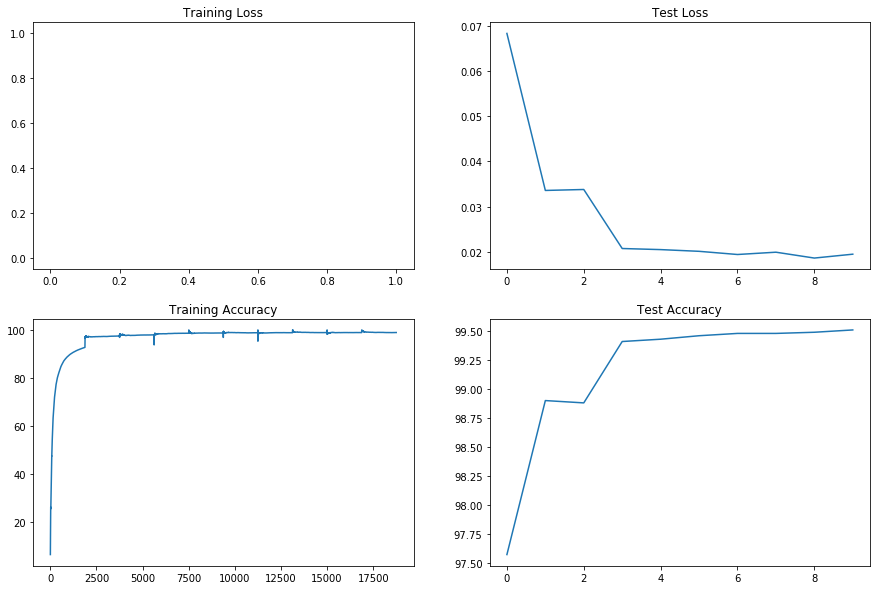

In [8]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses_l2)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [9]:
print (train_losses_l2)
print(len(train_losses_l2))

[]
0


AttributeError: ignored

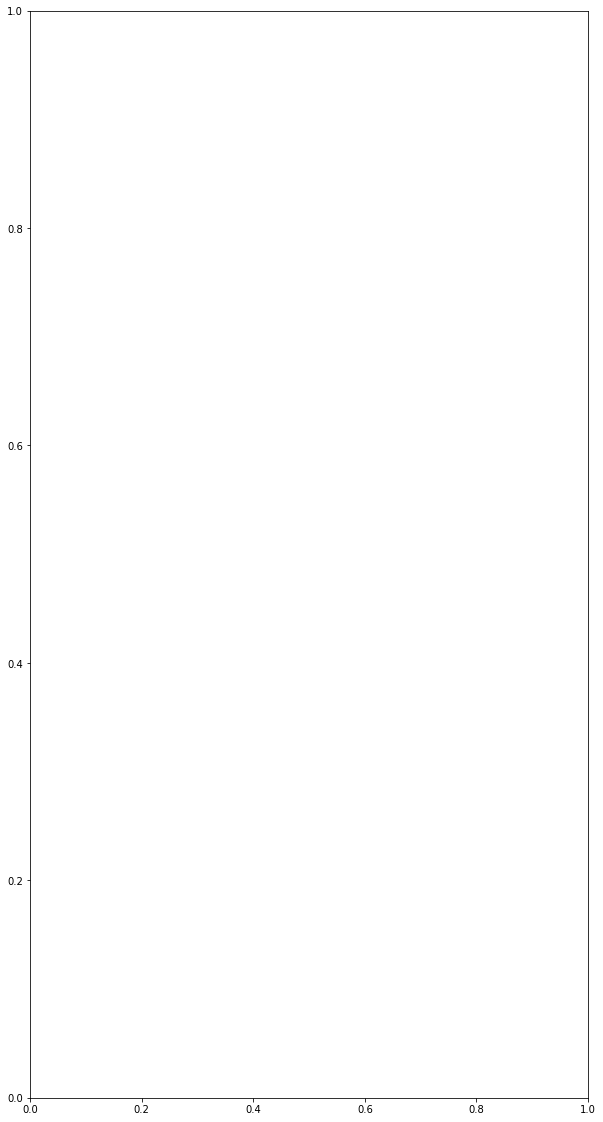

In [10]:
plt.figure(1,figsize=(10,20))
plt.plot(new_train_losses[10000:12000],fontsize=10)

In [0]:
import matplotlib.pyplot as plt
plt.xlabel('EPOCHS',fontsize=10)
plt.ylabel("LOSS",fontsize=10)
plt.figure(1,figsize=(20,8))
# Change the list function here to your loss function
plt.plot(train_losses_l2[10000:10100])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title("L1 LOSS Graph value")
plt.show()

Result 

1) We have achieved the accuracy of 99.42% crossing the threshold of 99.4% in under 15 epochs.

2) Image augmentation has helped us to increase the accuracy very so slightly.

3) Only one epoch was able to achieve above 99.4%. Consistency was maintained around 99.39%


In [0]:
def plot_losses(l1_loss,l2_loss,none_loss,both_loss):
  epochs=len(l1_loss)
  plt.figure(1,figsize=(10,6))
  plt.xticks(range(1,epochs+1),fontsize=15)
  plt.yticks(fontsize=10)
  plt.plot(range(1,epochs+1),l1_loss,'-b',label=' L1 LOSS')
  plt.plot(range(1,epochs+1),l2_loss,'-r',label=' L2 LOSS')
  plt.plot(range(1,epochs+1),none_loss,'-g',label=' No loss')
  plt.plot(range(1,epochs+1),both_loss,'-k',label=' L1 & L2 LOSS')
  plt.legend(loc=0,fontsize=15)
  plt.title("LOSS FUNCTIONS FOR {} EPOCHS".format(epochs))
  plt.show()

In [0]:
loss_list1=[10,20,30,40.5,50,16,25,-30]
loss_list2=[26,35,18,70.5,70,56,85,-40]
loss_list3=[16,29,36,48.5,58,17,24,-12]
loss_list4=[11,22,31,41.5,51,19,29,-34]

In [0]:
import matplotlib.pyplot as plt
plot_losses(loss_list1,loss_list2,loss_list3,loss_list4)